<a href="https://colab.research.google.com/github/cdsjg-iscteiul/Thesis_SiameseNetwork/blob/main/NeuralNetwok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from matplotlib.pyplot import figure
import os
import time
import pandas as pd
import seaborn as sn
import csv
import pickle
from statistics import mode
from sklearn.metrics import confusion_matrix
import itertools

random.seed(2222)

choose_network = "Pre-trained Model"
# choose_network = "Scratch Model"

# Database directory
base_dir = r'/content/drive/MyDrive/Database/Data_Test_2'
folder_list = os.listdir(base_dir)
print(folder_list)

number_files = sum([len(files) for r, d, files in os.walk(base_dir)])
print(number_files)


if choose_network == "Pre-trained Model":
  image_size_1 = 224
  image_size_2 = 224

elif choose_network == "Scratch Model":
  image_size_1 = 160
  image_size_2 = 160

  
print((image_size_1, image_size_2))

listOfFiles = []
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        listOfFiles.append(os.path.join(path, name))

copy_listOfFiles = listOfFiles
print(listOfFiles)

['IKEA_1', 'Bedroom_Lamp', 'LivingRoom_Lamp_1', 'LivingRoom_Lamp_2', 'IKEA_Bedside_Lamp', 'IKEA_Lamp_3', 'IKEA_Ceiling_Lamp', 'IKEA_Table_Lamp_2', 'LivingRoom_Lamp_3', 'Bedroom_Lamp_2', 'Office_Lamp', 'Bathroom_Lamp_2', 'IKEA_Ceiling_Lamp_5', 'IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lamp_3', 'IKEA_Desk_Lamp', 'IKEA_Ceiling_Lamp_Teto_2', 'IKEA_Bathroom_Lamp_2', 'IKEA_Bathroom_Lamp', 'IKEA_Desk_Lamp_4', 'IKEA_Table_Lamp', 'Bathroom_Lamp', 'IKEA_Table_Lamp_4', 'IKEA_Table_Lamp_3']
312
(224, 224)
['/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173336.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173343.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173344.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173338.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173335.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173347.jpg', '/content/drive/MyDrive/Database/Data

In [ ]:
epochs = 100
batch_size = 32
margin = 1  # Margin for constrastive loss.
train_test_split = 0.7

In [ ]:
def import_data(split):
    """ Cria Numpy Arrays semelhantes ao load data do mnist

    Argumentos:
      lista_imagens: lista contendo todas as imagens presentes na lista
      split: valor que vai determinar o split entre as imagens para treino e para teste

    Returns:
      Tuple no formato (x_train, y_train), (x_test, y_test) onde:
        x_train: Numpy Array de imagens com valores de pixels RBG de 0 a 255
        y_train: Numpy Array de labels de digitos
        x_test: Numpy Array de imagens 
        y_test:Numpy Array de Labels 
    """
    cat_list = []
    x = []
    y = []
    y_label = 0

    for folder_name in folder_list:
      files_list = os.listdir(os.path.join(base_dir, folder_name))
      temp=[]
      for file_name in files_list:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((28, 28))))
        y.append(y_label)
      y_label+=1
      cat_list.extend(temp)
  
    cat_list = np.asarray(cat_list)
    x = np.asarray(x)/255.0
    y = np.asarray(y)

    print(len(x))
    print(len(y))

   

    copy1 = x.tolist()
    copy2 = y.tolist()

    x_train = []
    y_train = []
    x_test = []
    y_test = []

    
    # number_of_train_pairs = int(len(x) * train_test_split)
    # number_test_pairs = int(len(x) - number_of_train_pairs)
    # print(number_of_train_pairs, ' pairs for training and ' ,number_test_pairs , 'of pairs for testing')

    for train in range(number_of_train_pairs):
      x_train.append(copy1.pop(0))
      y_train.append(copy2.pop(0))

    for test in range(number_test_pairs):
      x_test.append(copy1.pop(0))
      y_test.append(copy2.pop(0))
    

    del y

    return (np.asarray(x_train), np.asarray(y_train)), (np.asarray(x_test), np.asarray(y_test))

In [ ]:
def import_data_2():
  dataset_train = tf.keras.utils.image_dataset_from_directory(
   base_dir,
   color_mode='rgb',
   labels='inferred',
   label_mode = 'int',
   shuffle=True,
   seed = 2222,
   image_size= (image_size_1, image_size_2) ,
   batch_size= number_files,
    )
  
  dataset_test = tf.keras.utils.image_dataset_from_directory(
   base_dir,
   color_mode = 'rgb',
   labels='inferred',
   label_mode = 'int',
   shuffle=True,
   seed = 2222,
   image_size= (image_size_1, image_size_2),
   batch_size=number_files  )

  for images, labels in dataset_train:
    x_train = images.numpy()
    y_train = labels.numpy()
    # print(labels.numpy())

  x_test =  []
  y_test =  []
  for images, labels in dataset_test:
    x_test = images.numpy()
    y_test = labels.numpy()

  # for image_batch, labels_batch in dataset_train:
    # print(image_batch.shape)
    # print(labels_batch.numpy())
    # break
    
  x_train = x_train / 255.0
  x_test = x_test / 255.0

  class_names = dataset_train.class_names
  print(class_names)

  return (x_train, y_train) , (x_test, y_test)

In [ ]:
import_time_start = time.time()
(x_train_val, y_train_val), (x_test, y_test) = import_data_2()
print(x_train_val.shape)

import_time_end = time.time()

time_import = import_time_end - import_time_start 

print("TIME TO IMPORT ALL THE IMAGES DATA: ", time_import, "time_import")

# (x_train_val, y_train_val), (x_test, y_test) = import_data(train_test_split)

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

Found 312 files belonging to 24 classes.
Found 312 files belonging to 24 classes.
['Bathroom_Lamp', 'Bathroom_Lamp_2', 'Bedroom_Lamp', 'Bedroom_Lamp_2', 'IKEA_1', 'IKEA_Bathroom_Lamp', 'IKEA_Bathroom_Lamp_2', 'IKEA_Bedside_Lamp', 'IKEA_Ceiling_Lamp', 'IKEA_Ceiling_Lamp_3', 'IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lamp_5', 'IKEA_Ceiling_Lamp_Teto_2', 'IKEA_Desk_Lamp', 'IKEA_Desk_Lamp_4', 'IKEA_Lamp_3', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp_2', 'IKEA_Table_Lamp_3', 'IKEA_Table_Lamp_4', 'LivingRoom_Lamp_1', 'LivingRoom_Lamp_2', 'LivingRoom_Lamp_3', 'Office_Lamp']
(312, 224, 224, 3)
TIME TO IMPORT ALL THE IMAGES DATA:  116.45726728439331 time_import


In [ ]:
# Keep 50% of train_val  in validation set
# Mudar o valor dos 30000
number_spli = int(number_files * train_test_split)
x_train, x_val = x_train_val[:number_spli], x_train_val[number_spli:] 
print(x_train.shape)
print(x_val.shape)
y_train, y_val = y_train_val[:number_spli], y_train_val[number_spli:]
print(y_train.shape)
print(y_val.shape)
del x_train_val, y_train_val

(218, 224, 224, 3)
(94, 224, 224, 3)
(218,)
(94,)


In [ ]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    # print(num_classes)
    # print(digit_indices)

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        mid = digit_indices[label2]
        while len(mid) == 0:
          label2 = random.randint(0, num_classes - 1)
          mid = digit_indices[label2]
          print(mid)

        idx2 = random.choice(mid)
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [ ]:
from numpy.core.fromnumeric import shape
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
print(shape(x_train_1))
x_train_2 = pairs_train[:, 1]

(436, 224, 224, 3)


In [ ]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]

In [ ]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


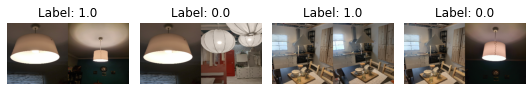

In [ ]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)


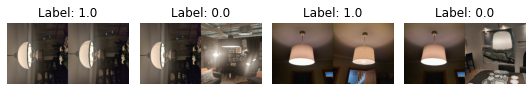

In [ ]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)


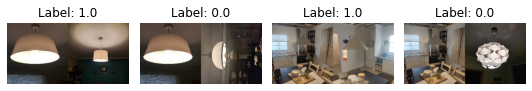

In [ ]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)


In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


In [ ]:
if choose_network == "Pre-trained Model":
  
    embedding_network = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", output_shape=[1280],
                   trainable=False, input_shape= ((224, 224, 3))),  # Can be True, see below.
    tf.keras.layers.Dense(20, activation='softmax'),
    layers.Flatten(),
    layers.Dense(20, activation="relu"),
    ])
    embedding_network.build([None, 224, 224, 3])  # Batch input shape.

elif choose_network == "Scratch Model":

    input = layers.Input((image_size_1, image_size_2, 3))
    x = tf.keras.layers.BatchNormalization()(input)
    x = layers.Conv2D(16, (5, 5), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(32, (5, 5), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (5, 5), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    

    x = layers.Flatten()(x)


    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Dense(20, activation="relu")(x)
    embedding_network = keras.Model(input, x)


print(embedding_network.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
Total params: 2,284,024
Trainable params: 26,040
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
#Defining the rest of the model
input_1 = tf.keras.layers.Input(shape=(20)) # Vetor das features resultado das towers 
input_2 = tf.keras.layers.Input(shape=(20)) #Especificar o shape 

merge_layer = tf.keras.layers.Lambda(euclidean_distance)([input_1, input_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)

merge_network = keras.Model(inputs=[input_1, input_2], outputs = output_layer)

merge_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1)           4           ['lambda[0][0]']             

In [ ]:
#Defining Model

input_1 = layers.Input((image_size_1, image_size_2, 3))
input_2 = layers.Input((image_size_1, image_size_2, 3))


tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)


output = merge_network([tower_1, tower_2])


siamese = keras.Model(inputs=[input_1, input_2], outputs=output)


In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


In [ ]:
#Training the towers

time_training_start = time.time()

# embedding_network.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])

# history_towers = embedding_network.fit(
#     x_train_1 + x_train_2,
#     labels_train,
#     validation_data=(x_val_1 + x_val_2, labels_val),
#     batch_size=batch_size,
#     epochs=epochs,
# )


In [ ]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 20)           2284024     ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

In [ ]:
history_siamese = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

time_training_end = time.time()

results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)


Epoch 1/100
14/14 [==============================] - 15s 282ms/step - loss: 0.2301 - accuracy: 0.8096 - val_loss: 0.2438 - val_accuracy: 0.7181
Epoch 2/100
14/14 [==============================] - 2s 115ms/step - loss: 0.2189 - accuracy: 0.9587 - val_loss: 0.2414 - val_accuracy: 0.7660
Epoch 3/100
14/14 [==============================] - 2s 116ms/step - loss: 0.2141 - accuracy: 0.9725 - val_loss: 0.2390 - val_accuracy: 0.8191
Epoch 4/100
14/14 [==============================] - 2s 117ms/step - loss: 0.2096 - accuracy: 0.9885 - val_loss: 0.2363 - val_accuracy: 0.8617
Epoch 5/100
14/14 [==============================] - 2s 116ms/step - loss: 0.2055 - accuracy: 0.9885 - val_loss: 0.2331 - val_accuracy: 0.8777
Epoch 6/100
14/14 [==============================] - 2s 116ms/step - loss: 0.2014 - accuracy: 0.9817 - val_loss: 0.2299 - val_accuracy: 0.8936
Epoch 7/100
14/14 [==============================] - 2s 117ms/step - loss: 0.1974 - accuracy: 0.9862 - val_loss: 0.2261 - val_accuracy: 0.904

In [ ]:
print("Training Time:")
print(time_training_end -time_training_start )

Training Time:
174.95230984687805


IMPORT TRAINED MODEL

In [ ]:
def load_models():
  if choose_network == "Pre-trained Model":
    siamese = tf.keras.models.load_model('/content/drive/MyDrive/Database/Models/siamese_trained.h5')
  
    merge_network = tf.keras.models.load_model('/content/drive/MyDrive/Database/Models/merge_network_trained.h5')

    tower = tf.keras.models.load_model('/content/drive/MyDrive/Database/Models/tower_trained.h5')

  else:
    siamese = tf.keras.models.load_model('/content/drive/MyDrive/Database/Models/siamese_scratch.h5')

    merge_network = tf.keras.models.load_model('/content/drive/MyDrive/Database/Models/merge_network_scratch.h5')

    tower = tf.keras.models.load_model('/content/drive/MyDrive/Database/Models/tower_scratch.h5')


# load_models()
# print(siamese.summary())


In [ ]:
#Guardar os modelos num ficheiro

if choose_network == "Pre-trained Model":

  siamese.save("/content/drive/MyDrive/Database/Models/siamese_trained")
  merge_network.save("/content/drive/MyDrive/Database/Models/merge_network_trained")
  embedding_network.save("/content/drive/MyDrive/Database/Models/tower_trained")


else:

  converter = tf.lite.TFLiteConverter.from_keras_model(siamese)
  tflite_model = converter.convert()

  open("/content/drive/MyDrive/Database/Models/siamese_scratch.h5", "wb").write(tflite_model)



  converter = tf.lite.TFLiteConverter.from_keras_model(merge_network)
  tflite_model = converter.convert()

  open("/content/drive/MyDrive/Database/Models/merge_network_scratch.h5", "wb").write(tflite_model)


  converter = tf.lite.TFLiteConverter.from_keras_model(embedding_network)
  tflite_model_1 = converter.convert()

  open("/content/drive/MyDrive/Database/Models/tower_scratch.h5", "wb").write(tflite_model_1)

# siamese.save("/content/drive/MyDrive/Database/Models/Siamese.tflite")
# embedding_network.save("/content/drive/MyDrive/Database/Models/Towers.tflite")

In [ ]:
time_trained = time_training_end - time_training_start

print(time_trained)


174.95230984687805


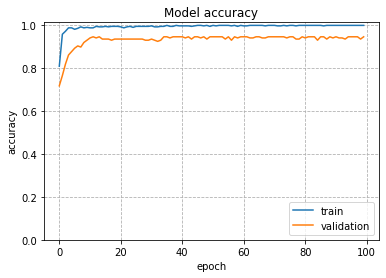

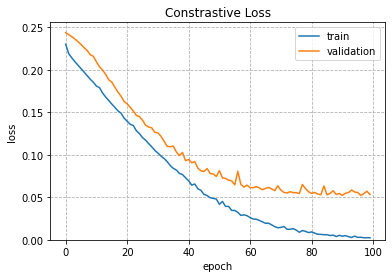

In [ ]:
def plt_metric(history, metric, title, has_valid=True):

    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="lower right")
        plt.ylim(bottom=0)
    plt.title(title)
    plt.grid(True, ls = "--")
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()
   

def plt_metric_loss(history, metric, title, has_valid=True):

    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper right")
        plt.ylim(bottom=0)
    plt.title(title)
    plt.grid(True, ls = "--")
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()
    

# Plot the accuracy
plt_metric(history=history_siamese.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric_loss(history=history_siamese.history, metric="loss", title="Constrastive Loss")


Como ver as melhores imagens do conjunto de teste e do conjunto de validação?

1. Ver a diferença entre o valor real o True e fazer a diferença entre isso e o valor da prediction e os que tiverem menor diferença são as melhores imagens
2.   List item


  

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, labelpad= 10)
    plt.yticks(tick_marks, classes, labelpad=10)
    plt.tight_layout()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


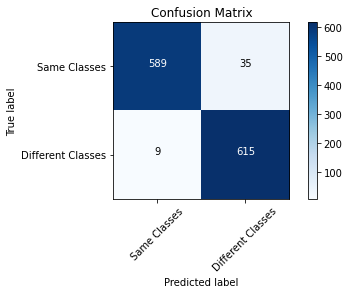

In [ ]:
all_predictions = np.array([])
all_labels = np.array([])

predictions_test = siamese([x_test_1, x_test_2])
all_predictions = predictions_test.numpy()
predictions_train = siamese([x_train_1, x_train_2])
all_predictions = np.concatenate([all_predictions, predictions_train])
predictions_val = siamese([x_val_1, x_val_2])
all_predictions = np.concatenate([all_predictions, predictions_val])


all_labels = labels_test
all_labels = np.concatenate([all_labels, labels_train])
all_labels = np.concatenate([all_labels, labels_val])


cm = confusion_matrix(y_true=all_labels, y_pred=all_predictions.round())

cm_plot_labels = ["Same Classes", "Different Classes"]

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


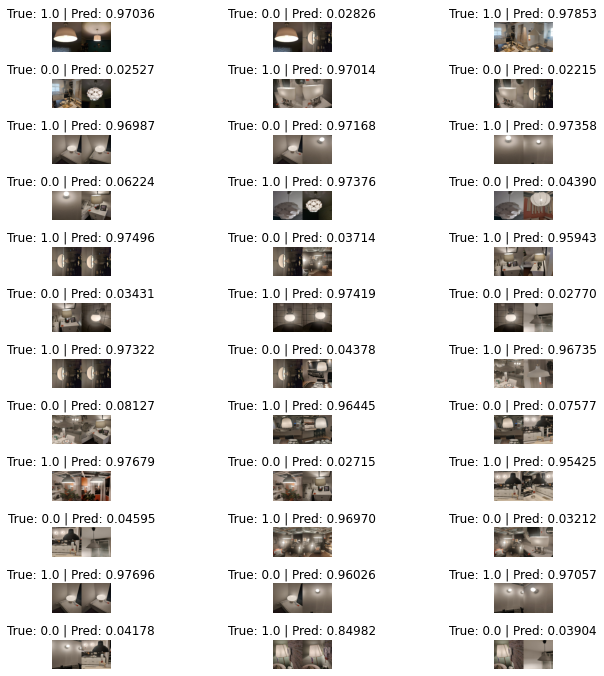

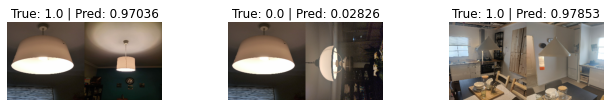

In [ ]:
predictions = siamese([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=36, predictions=predictions, test=True)

visualize(pairs_test, labels_test, to_show= 3, predictions=predictions, test=True)

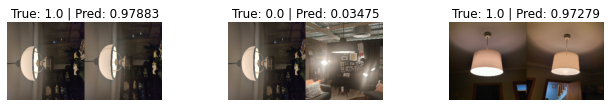

In [ ]:
predictions = siamese([x_val_1, x_val_2])
visualize(pairs_val, labels_val, to_show=3, predictions=predictions, test=True)

In [ ]:
import time

image_path = "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Ceiling_Lamp_5/IMG_20220325_172315.jpg"
image_path_2 = "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Ceiling_Lamp_4/IMG_20220325_171953.jpg"

start = time.time()

image_test_1 = tf.keras.utils.load_img(image_path, target_size= (image_size_1,image_size_2))
input_arr_1 = tf.keras.preprocessing.image.img_to_array(image_test_1)
input_arr_1 = np.array([input_arr_1])/255  # Convert single image to a batch.
# print(input_arr_1)
# print(type(input_arr_1))

# print(x)
image_test_2 = tf.keras.utils.load_img(image_path_2, target_size= (image_size_1,image_size_2))
input_arr_2 = tf.keras.preprocessing.image.img_to_array(image_test_2)
input_arr_2 = np.array([input_arr_2])/255  # Convert single image to a batch.



output= siamese([input_arr_1,input_arr_2])
output= output.numpy()
# print(output)


# print(end - start)

# print(input_arr_1)
predictions = siamese([input_arr_1, input_arr_1])
predictions = predictions.numpy()
np.set_printoptions(precision=4, suppress = False)
end = time.time()

print("Tempo para correr o sistema todo para 2 inputs dados:")
print(end - start)

print(predictions)


Tempo para correr o sistema todo para 2 inputs dados:
0.6257226467132568
[[0.9801]]


Guardar Features

In [ ]:
def writeAllFeatures(listFiles):
    print(listFiles)


    data = {'Path': [] ,
            'Class': [] ,
            'Name': [] ,
            'Features': []}

    df_marks = pd.DataFrame(data)
    for x in listFiles:
      # print(x) #Print Current File Name

      

      image_test = tf.keras.utils.load_img(x, target_size= (image_size_1,image_size_2))
      input_arr= tf.keras.preprocessing.image.img_to_array(image_test)
      input_arr = np.array([input_arr])/255  # Convert single image to a batch.
      
      features = embedding_network(input_arr)
      # print(features_list)

      path_splitted = x.split("/")
      
      new_row = {'Path': x, 'Class':path_splitted[6], 'Name':path_splitted[7], 'Features': features}
      df_marks = df_marks.append(new_row, ignore_index=True)

    # print(df_marks) #Print to ficheiro todo 
    df_marks.to_pickle("/content/drive/MyDrive/Database/Saved_Features/Features.pkl")

In [ ]:
time_start_features = time.time()

writeAllFeatures(listOfFiles)

time_end_features = time.time()

time_features = time_end_features - time_start_features
print("Tempo para guardar as features num ficheiro:")
print(time_features)

['/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173336.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173343.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173344.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173338.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173335.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173347.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173342.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173341.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173340.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173339.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173346.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173345.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_2022032

In [ ]:
#TESTAR fazer predition com as features de duas imagens

imagePath_1 =  "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Ceiling_Lamp_5/IMG_20220325_172315.jpg"

image_test_1 = tf.keras.utils.load_img(imagePath_1, target_size= (image_size_1,image_size_2))
input_arr_1 = tf.keras.preprocessing.image.img_to_array(image_test_1)
input_arr_1  = np.array([input_arr_1])/255  # Convert single image to a batch.
  
features_1 = embedding_network(input_arr_1)
features_list_1 = features_1.numpy()

imagePath_2 =  "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Ceiling_Lamp_5/IMG_20220325_172315.jpg"

image_test_2 = tf.keras.utils.load_img(imagePath_2, target_size= (image_size_1,image_size_2))
input_arr_2 = tf.keras.preprocessing.image.img_to_array(image_test_2)
input_arr_2  = np.array([input_arr_2])/255  # Convert single image to a batch.

features_2 = embedding_network(input_arr_2)
features_list_2 = features_2.numpy()
print("FEATURES")
print(features_list_2)

print(features_list_1)
print("END")
predictions = merge_network([features_list_1, features_list_2])
predictions = predictions.numpy()
np.set_printoptions(precision=4, suppress = False)
print(predictions)



FEATURES
[[0.     0.     0.219  0.36   0.0925 0.4099 0.     0.2122 0.2348 0.1925
  0.     0.2226 0.     0.3226 0.0975 0.     0.     0.     0.0349 0.    ]]
[[0.     0.     0.219  0.36   0.0925 0.4099 0.     0.2122 0.2348 0.1925
  0.     0.2226 0.     0.3226 0.0975 0.     0.     0.     0.0349 0.    ]]
END
[[0.9801]]


Como ver a qual classe pertence uma imagem?


1.   Ver a imagem mais semelhante à imagem dada e classe é a da mais semelhante
2.   Ver as K imagens mais semelhantes e a classe que tiver mais imagens nessas K é a classe da imagem ( K tipo 3 a 7)
3.   Ver a média de cada classe e a classe que tiver melhor média é a classe da imagem dada



In [ ]:
def most_similar_Image_noPrints(imagePath):
  path_best_result= None #Path da imagem mais semelhante
  most_similar = -1 # Valor da semelhança

  df = pd.read_pickle('/content/drive/MyDrive/Database/Saved_Features/Features.pkl')
  features_as_list = df['Features'].tolist()
  paths_as_list = df['Class'].tolist()

  # Get features of image form the path given as argument
  image_test = tf.keras.utils.load_img(imagePath, target_size= (image_size_1,image_size_2))
  input_arr= tf.keras.preprocessing.image.img_to_array(image_test)
  input_arr = np.array([input_arr])/255  # Convert single image to a batch.
  
  features = embedding_network(input_arr)
  features_list = features.numpy()

  for idx, x in enumerate(features_as_list):
    predictions = merge_network([features_list, features_as_list[idx]])
    predictions = predictions.numpy()
    similarity = predictions[0][0]
    output = f"{similarity:.9f}"
  
    if output > str(most_similar):
      most_similar = output
      path_best_result = paths_as_list[idx]
  

  return path_best_result

['IKEA_1', 'Bedroom_Lamp', 'LivingRoom_Lamp_1', 'LivingRoom_Lamp_2', 'IKEA_Bedside_Lamp', 'IKEA_Lamp_3', 'IKEA_Ceiling_Lamp', 'IKEA_Table_Lamp_2', 'LivingRoom_Lamp_3', 'Bedroom_Lamp_2', 'Office_Lamp', 'Bathroom_Lamp_2', 'IKEA_Ceiling_Lamp_5', 'IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lamp_3', 'IKEA_Desk_Lamp', 'IKEA_Ceiling_Lamp_Teto_2', 'IKEA_Bathroom_Lamp_2', 'IKEA_Bathroom_Lamp', 'IKEA_Desk_Lamp_4', 'IKEA_Table_Lamp', 'Bathroom_Lamp', 'IKEA_Table_Lamp_4', 'IKEA_Table_Lamp_3']
Confusion matrix, without normalization


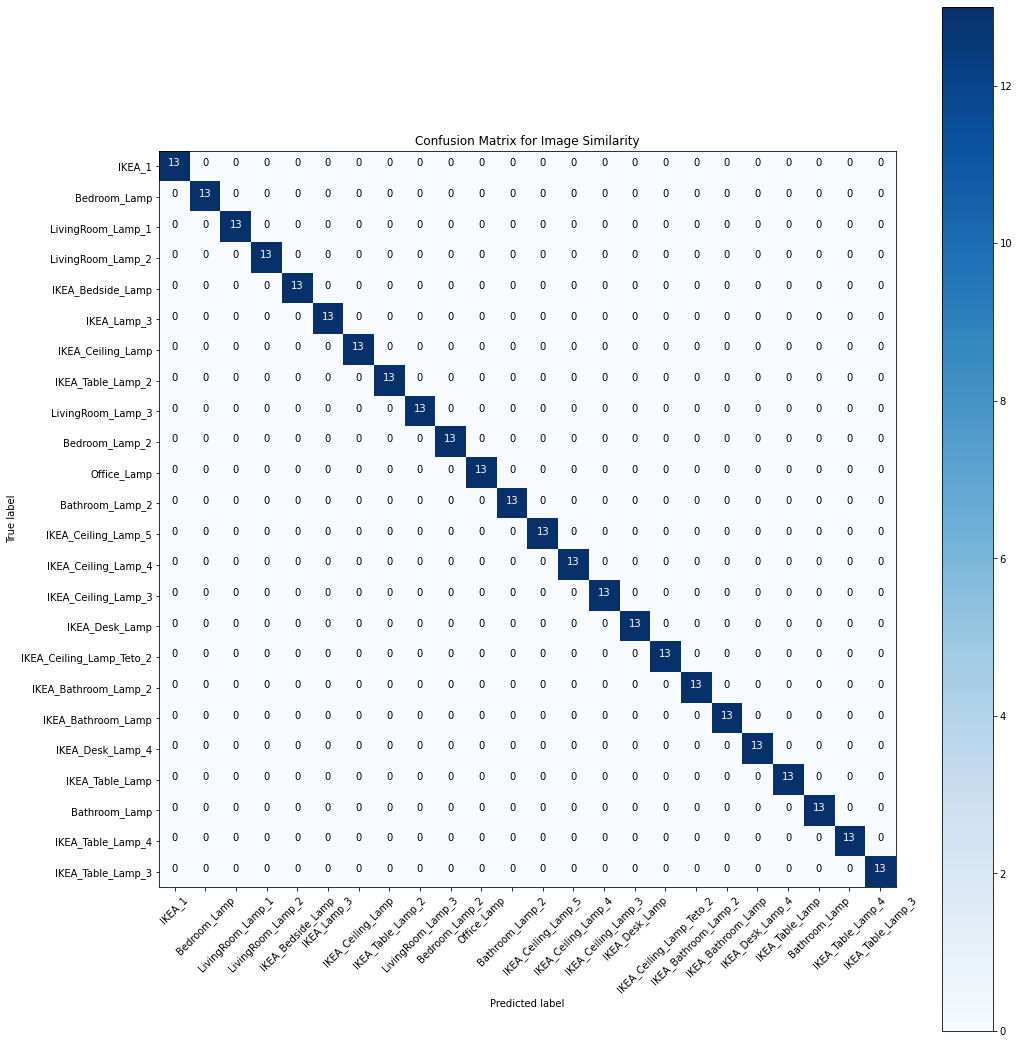

In [ ]:
list_true_pred = []
list_results = []

for x in listOfFiles:
  path_splitted = x.split("/")
  if path_splitted[6] == "Kitchen_Lamp":
    print("??????")
  else:
    list_true_pred.append(path_splitted[6])

    result = most_similar_Image_noPrints(x)
    list_results.append(result)


cm = confusion_matrix(y_true=list_true_pred, y_pred=list_results)

cm_plot_labels = folder_list
print(folder_list)

fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix for Image Similarity')

In [ ]:
def most_similar_Image(imagePath):

  #Fazer o tempo por par

  path_best_result= None #Path da imagem mais semelhante
  most_similar = -1 # Valor da semelhança

 #Tempo para importar os ficheiro de features
  time_import_file_start = time.time()
  df = pd.read_pickle('/content/drive/MyDrive/Database/Saved_Features/Features.pkl')
  features_as_list = df['Features'].tolist()
  paths_as_list = df['Class'].tolist()

  time_import_file_end = time.time()
  print("Tempo para importar o ficheiro com as features de todo o dataset")
  print(time_import_file_end - time_import_file_start )

  #Tempo para correr a torre  
  time_start_tower = time.time()

  # Get features of image form the path given as argument
  image_test = tf.keras.utils.load_img(imagePath, target_size= (image_size_1,image_size_2))
  input_arr= tf.keras.preprocessing.image.img_to_array(image_test)
  input_arr = np.array([input_arr])/255  # Convert single image to a batch.
  
  features = embedding_network(input_arr)
  features_list = features.numpy()

  time_end_tower = time.time()

  print("Tempo para fazer o processamento das features de uma imagem:")
  print(time_end_tower -  time_start_tower)


  time_start_images = time.time()
  for idx, x in enumerate(features_as_list):
    predictions = merge_network([features_list, features_as_list[idx]])
    predictions = predictions.numpy()
    similarity = predictions[0][0]
    output = f"{similarity:.9f}"
  
    if output > str(most_similar):
      most_similar = output
      path_best_result = paths_as_list[idx]
  
  time_end_images = time.time()

  print("Tempo para ler as features de todas as imagens guardadas com a dada e ver a mais semelhante")
  print(time_end_images - time_start_images)

  return path_best_result



time_start_predict_most = time.time()

result = most_similar_Image("/content/drive/MyDrive/Database/Teste/IMG_20220720_111551.jpg")
print(result)


time_end_predict_most = time.time()

time_to_predict_most = time_end_predict_most - time_start_predict_most

print("Tempo para importar ficheiro + processamento das features da imagem dada + ler as features de todas e ver a mais semelhante")
print(time_to_predict_most) #seconds

Tempo para importar o ficheiro com as features de todo o dataset
0.04562211036682129
Tempo para fazer o processamento das features de uma imagem:
1.2535688877105713
Tempo para ler as features de todas as imagens guardadas com a dada e ver a mais semelhante
0.682466983795166
Bedroom_Lamp
Tempo para importar ficheiro + processamento das features da imagem dada + ler as features de todas e ver a mais semelhante
1.9839398860931396


In [ ]:
def K_Similar(imagePath, k): #https://stackoverflow.com/questions/53387996/replace-min-max-value-in-a-list
  # print("Most K Similar Class")

  list_kbest_results= [-1] * k # Lista mais semelhantes
  class_best_results= [None] * k #Path da imagem mais semelhante

  df = pd.read_pickle('/content/drive/MyDrive/Database/Saved_Features/Features.pkl')
  features_as_list = df['Features'].tolist()
  class_as_list = df['Class'].tolist()

  # Get features of image form the path given as argument
  image_test = tf.keras.utils.load_img(imagePath, target_size= (image_size_1,image_size_2))
  input_arr= tf.keras.preprocessing.image.img_to_array(image_test)
  input_arr = np.array([input_arr])/255  # Convert single image to a batch.
  
  features = embedding_network(input_arr)
  features_list = features.numpy()

  for idx, x in enumerate(features_as_list):
    predictions = merge_network([features_list, features_as_list[idx]])
    predictions = predictions.numpy()
    similarity = predictions[0][0]
    output = f"{similarity:.9f}"
    compare = float(output)


    new_list = []
    new_list_class = []

    # print(max(list_kbest_results))

    if compare > min(list_kbest_results):
      list_kbest_results[list_kbest_results.index(min(list_kbest_results))] = compare
      class_best_results[list_kbest_results.index(min(list_kbest_results))] = class_as_list[idx]


  print(class_best_results)
  print(max(set(class_best_results), key=class_best_results.count))
  return max(set(class_best_results), key=class_best_results.count)
  # print(mode(class_best_results))
  

time_start_k = time.time()

list_test = ["/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171447.jpg", "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171448.jpg",
             "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171449.jpg", "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171450.jpg",
             "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171451.jpg", "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171452.jpg",
             "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171453.jpg", "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171453__01.jpg",
             "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171506.jpg", "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171507.jpg",
             "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171508.jpg", "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171510.jpg",
             "/content/drive/MyDrive/Database/Data_Test_2/IKEA_Table_Lamp/IMG_20220325_171511.jpg"]

for x in list_test:
  result = K_Similar(x, 7)
time_end_k = time.time()

time_k = time_end_k - time_start_k 
print(time_k) #Seconds

['IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lamp_4', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Ceiling_Lamp_4', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp']
IKEA_Table_Lamp
['IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lamp_4', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Ceiling_Lamp_4']
IKEA_Ceiling_Lamp_4
['IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp']
IKEA_Table_Lamp
['IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp']
IKEA_Table_Lamp
['IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp']
IKEA_Table_Lamp
['IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp', 'IKEA_Table_Lamp']
IKEA_Table_Lamp
['IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lam

[None, 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'LivingRoom_Lamp_1']
IKEA_1
['IKEA_Table_Lamp_4', 'IKEA_1', 'IKEA_1', 'IKEA_Table_Lamp_4', 'IKEA_Table_Lamp_4', 'IKEA_1', 'IKEA_Table_Lamp_4']
IKEA_Table_Lamp_4
['IKEA_Table_Lamp_4', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_Table_Lamp_4']
IKEA_1
['IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1']
IKEA_1
[None, 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_Table_Lamp_2']
IKEA_1
[None, 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1']
IKEA_1
['IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1']
IKEA_1
['IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1']
IKEA_1
['IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_Table_Lamp_4']
IKEA_1
['IKEA_Table_Lamp_4', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_Table_Lamp_4']
IKEA_1
['IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1', 'IKEA_1']
IKEA_1
[None, 'IKEA_1', 'IKEA

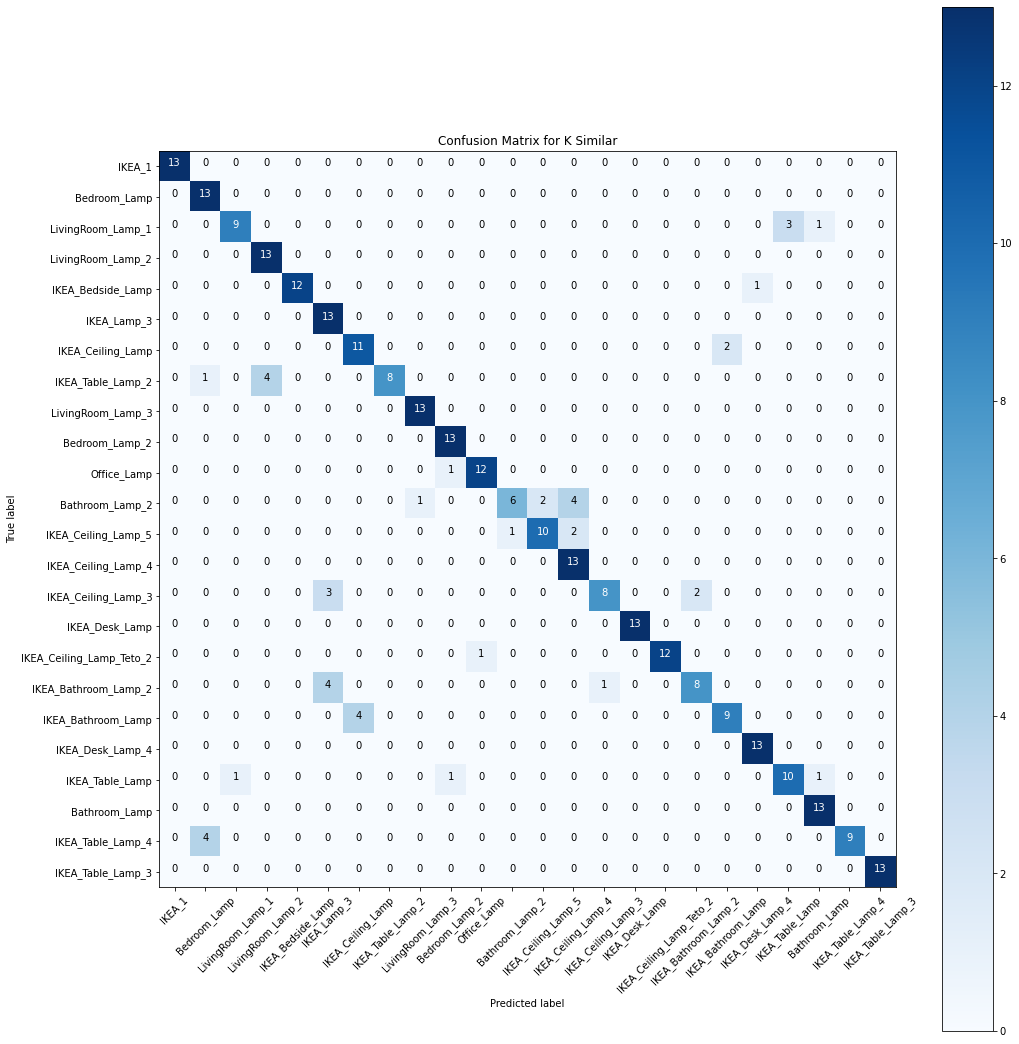

In [ ]:
list_true_pred = []
list_results = []

for x in listOfFiles:
  path_splitted = x.split("/")
  if path_splitted[6] == "Kitchen_Lamp":
    print("??????")
  else:
    list_true_pred.append(path_splitted[6])

    result = K_Similar(x, 7)
    list_results.append(result)


cm = confusion_matrix(y_true=list_true_pred, y_pred=list_results)

cm_plot_labels = folder_list

fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix for K Similar')

In [ ]:
def guess_Class(imagePath, k):

  list_kbest_results= [None] * k

  list_best_result= [None]

  # Get features of image form the path given as argument
  image_test = tf.keras.utils.load_img(imagePath, target_size= (image_size_1,image_size_2))
  input_arr= tf.keras.preprocessing.image.img_to_array(image_test)
  input_arr = np.array([input_arr])/255  # Convert single image to a batch.
  
  features = embedding_network(input_arr)
  features_list = features.numpy()

  df = pd.read_pickle('/content/drive/MyDrive/Database/Saved_Features/Features.pkl')
  features_as_list = df['Features'].tolist()
  paths_as_list = df['Class'].tolist()

  #Teste do processo todo para uma só imagem

  predictions = merge_network([features_list, features_as_list[1]])
  predictions = predictions.numpy()
  similarity = predictions[0][0]
  output = f"{similarity:.9f}"
  print(output)


guess_Class("/content/drive/MyDrive/Database/Data_Test_2/IKEA_Ceiling_Lamp_5/IMG_20220325_172315.jpg", 7)




0.035507683


In [ ]:
# Teste de adicionar uma classe nova sem fazer o treino


lista_imagens_path = ["/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20220725_082027.jpg", "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20220725_082028.jpg",
                       "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20220725_082030.jpg", "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20220725_082031.jpg",
                      "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20220725_082036.jpg", "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20220725_082038.jpg",
                      "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20221130_201420.jpg", "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20221130_201422.jpg",
                      "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20221130_201424.jpg", "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20221130_201431.jpg",
                      "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20221130_201432.jpg", "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20221130_201434.jpg",
                      "/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20221130_201436.jpg"]

new_Class_name = "Kitchen_Lamp"
def add_newClass(listaImagens, className):
  lista_numpy_ficheiro = []

  time_read_file = time.time()
  df = pd.read_pickle('/content/drive/MyDrive/Database/Saved_Features/Features.pkl')



  print("Tempo para ler o ficheiro pickle onde estão guardadas as features")
  print(time_start_add_images - time_read_file)

  for x in listaImagens:
    image_test = tf.keras.utils.load_img(x, target_size= (image_size_1,image_size_2))
    input_arr= tf.keras.preprocessing.image.img_to_array(image_test)
    input_arr = np.array([input_arr])/255  # Convert single image to a batch.
  
    features = embedding_network(input_arr)
    lista_numpy_ficheiro.append(features)

    listOfFiles.append(x)
    path_splitted = x.split("/")
      
    new_row = {'Path': x, 'Class':path_splitted[6], 'Name':path_splitted[7], 'Features': features}
    df = df.append(new_row, ignore_index=True)

  folder_list.append(className)
  df.to_pickle("/content/drive/MyDrive/Database/Saved_Features/Features.pkl")


  

time_start_add_images = time.time()

add_newClass(lista_imagens_path, new_Class_name)

time_end_add_images = time.time()
print("Tempo para ler as features de um conjunto de imagens novas e adicionar ao ficheiro das antigas features:")
print(time_end_add_images - time_start_add_images)

Tempo para ler o ficheiro pickle onde estão guardadas as features
-2.7894973754882812e-05
Tempo para ler as features de um conjunto de imagens novas e adicionar ao ficheiro das antigas features:
16.134239196777344


In [ ]:
#Run most similar to new image

time_start_newClass = time.time()

result = most_similar_Image("/content/drive/MyDrive/Database/Teste/Kitchen_Lamp/IMG_20220725_082028.jpg")

print(result)
time_end_newClass = time.time()

print("Time to run the most similar image for the new class that was added without training")
print(time_end_newClass - time_start_newClass)

Tempo para importar o ficheiro com as features de todo o dataset
0.040937185287475586
Tempo para fazer o processamento das features de uma imagem:
0.1722097396850586
Tempo para ler as features de todas as imagens guardadas com a dada e ver a mais semelhante
0.7362134456634521
Kitchen_Lamp
Time to run the most similar image for the new class that was added without training
0.9524819850921631


['IKEA_1', 'Bedroom_Lamp', 'LivingRoom_Lamp_1', 'LivingRoom_Lamp_2', 'IKEA_Bedside_Lamp', 'IKEA_Lamp_3', 'IKEA_Ceiling_Lamp', 'IKEA_Table_Lamp_2', 'LivingRoom_Lamp_3', 'Bedroom_Lamp_2', 'Office_Lamp', 'Bathroom_Lamp_2', 'IKEA_Ceiling_Lamp_5', 'IKEA_Ceiling_Lamp_4', 'IKEA_Ceiling_Lamp_3', 'IKEA_Desk_Lamp', 'IKEA_Ceiling_Lamp_Teto_2', 'IKEA_Bathroom_Lamp_2', 'IKEA_Bathroom_Lamp', 'IKEA_Desk_Lamp_4', 'IKEA_Table_Lamp', 'Bathroom_Lamp', 'IKEA_Table_Lamp_4', 'IKEA_Table_Lamp_3', 'Kitchen_Lamp']
['/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173336.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173343.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173344.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173338.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173335.jpg', '/content/drive/MyDrive/Database/Data_Test_2/IKEA_1/IMG_20220325_173347.jpg', '/content/drive/MyDrive/Database/Dat

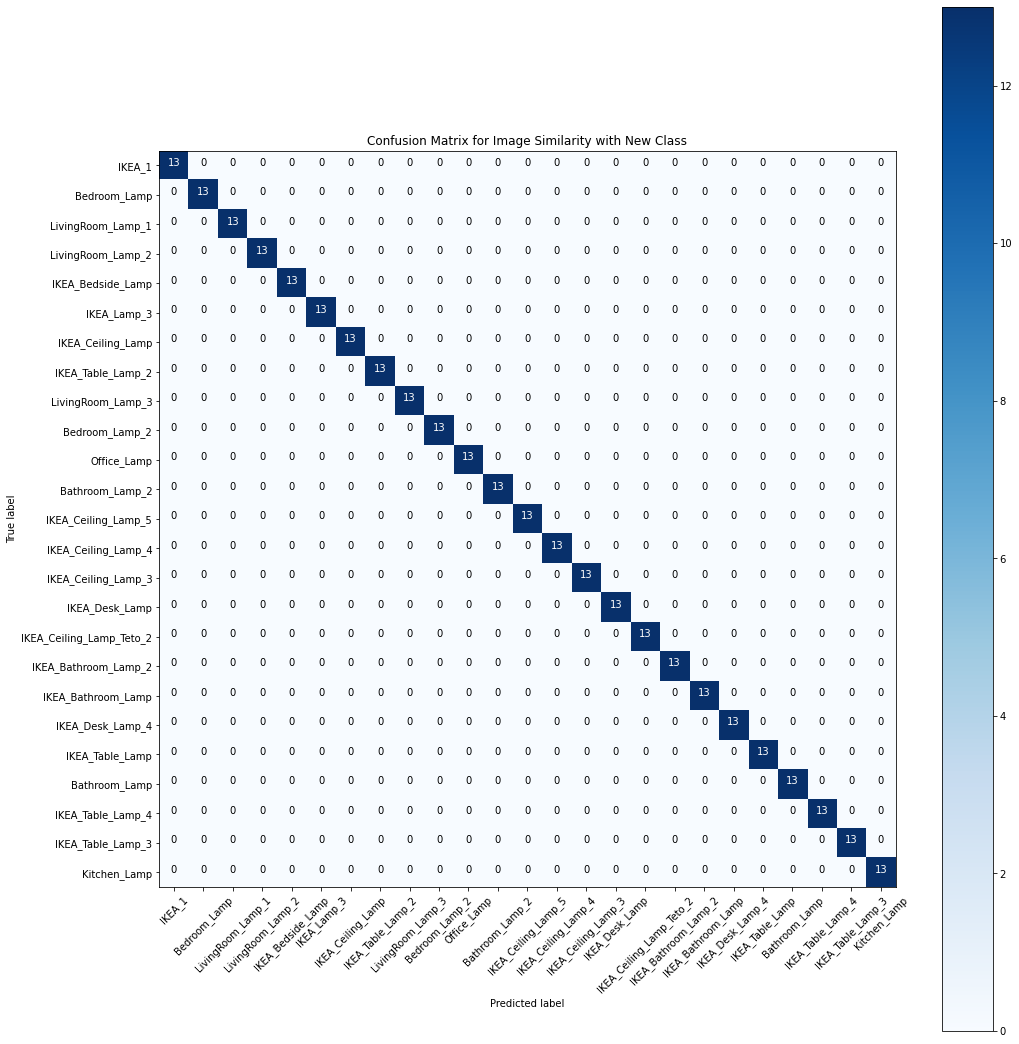

In [ ]:
list_true_pred = []
list_results = []
print(folder_list)
print(listOfFiles)
for x in listOfFiles:
  path_splitted = x.split("/")
  list_true_pred.append(path_splitted[6])
  if path_splitted[6] == 'IKEA_Table_Lamp':
    print(x)

  result = most_similar_Image_noPrints(x)
  list_results.append(result)


cm = confusion_matrix(y_true=list_true_pred, y_pred=list_results)

cm_plot_labels = folder_list
print(folder_list)

fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix for Image Similarity with New Class')